**Импорты**

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import xgboost as xgb

**Загружаем датасет, смотрим признаки**

In [126]:
data = pd.read_csv('spaceship_titanic.csv').dropna()
data = data.reset_index(drop=True)
print(data.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


**Нормализуем численные и убираем категориальные признаки**

In [127]:
data = data.drop(['PassengerId', 'Name'], axis=1)

categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 
                        'Destination', 'VIP']
numeric_features = ['Age', 'RoomService', 'FoodCourt', 
                    'ShoppingMall', 'Spa', 'VRDeck']

data[numeric_features] = data[numeric_features].astype(float)
data['Transported'] = LabelEncoder().fit_transform(data['Transported'])

# Числовые признаки
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Уберем категориальные признаки
data_no_category = data.drop(categorical_features, axis=1)

print(data_no_category)

           Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0     0.695413    -0.345756  -0.285355     -0.309494 -0.273759 -0.269534   
1    -0.336769    -0.176748  -0.279993     -0.266112  0.206165 -0.230494   
2     2.002842    -0.279083   1.845163     -0.309494  5.596357 -0.226058   
3     0.282540    -0.345756   0.479034      0.334285  2.636384 -0.098291   
4    -0.887266     0.124056  -0.243650     -0.047470  0.220152 -0.267759   
...        ...          ...        ...           ...       ...       ...   
6601  0.833037    -0.345756   3.777285     -0.309494  1.162518 -0.203876   
6602 -0.749641    -0.345756  -0.285355     -0.309494 -0.273759 -0.269534   
6603 -0.199145    -0.345756  -0.285355      2.938900 -0.272885 -0.269534   
6604  0.213728    -0.345756   0.339621     -0.309494  0.034826  2.600774   
6605  1.039473    -0.150389   2.507673     -0.309494 -0.273759 -0.258887   

      Transported  
0               0  
1               1  
2               0  
3      

**Разделим данные на train и test**

In [128]:
x_no_category = data_no_category.drop(['Transported'], axis=1)
y_no_category = data_no_category['Transported']

x_no_category_train, x_no_category_test, y_no_category_train, y_no_category_test = train_test_split(
    x_no_category, y_no_category, test_size=0.2, random_state=1
)

**Построим модель линейной регрессии**

In [129]:
linear_regression = LinearRegression()
linear_regression.fit(x_no_category_train, y_no_category_train)

predict_no_category = linear_regression.predict(x_no_category_test)

**Попробуем оценить точность**

In [130]:
all_cases = x_no_category_test.shape[0]
true_predict_cases = 0
for true, predict in zip(y_no_category_test, predict_no_category):
    if true == 1 and predict > 0.54:
        true_predict_cases += 1
    if true == 0 and predict <= 0.54:
        true_predict_cases += 1

print('"Accuracy": ', true_predict_cases / all_cases)

"Accuracy":  0.7708018154311649


**Построим модель бустинга**

In [131]:
xgb_model = xgb.XGBClassifier(n_estimators=7, max_depth=4)
xgb_model.fit(x_no_category_train, y_no_category_train)

predict = xgb_model.predict(x_no_category_test)

print('Accuracy: {}'.format(accuracy_score(y_no_category_test, predict)))

Accuracy: 0.7987897125567323


**Теперь применим One Hot и Target encoding'и**

In [132]:
onehot_enc = OneHotEncoder()

data_onehot = data.copy()
data_onehot[categorical_features] = data_onehot[categorical_features].astype('category')
for feature in categorical_features:
    data_onehot[feature] = data_onehot[feature].cat.codes
onehot_encoded_data = pd.DataFrame(onehot_enc.fit_transform(data_onehot[categorical_features]).toarray())
data_onehot = data_onehot.drop(categorical_features, axis=1)
data_onehot = data_onehot.join(onehot_encoded_data)

print(data_onehot)

           Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0     0.695413    -0.345756  -0.285355     -0.309494 -0.273759 -0.269534   
1    -0.336769    -0.176748  -0.279993     -0.266112  0.206165 -0.230494   
2     2.002842    -0.279083   1.845163     -0.309494  5.596357 -0.226058   
3     0.282540    -0.345756   0.479034      0.334285  2.636384 -0.098291   
4    -0.887266     0.124056  -0.243650     -0.047470  0.220152 -0.267759   
...        ...          ...        ...           ...       ...       ...   
6601  0.833037    -0.345756   3.777285     -0.309494  1.162518 -0.203876   
6602 -0.749641    -0.345756  -0.285355     -0.309494 -0.273759 -0.269534   
6603 -0.199145    -0.345756  -0.285355      2.938900 -0.272885 -0.269534   
6604  0.213728    -0.345756   0.339621     -0.309494  0.034826  2.600774   
6605  1.039473    -0.150389   2.507673     -0.309494 -0.273759 -0.258887   

      Transported    0    1    2  ...  5305  5306  5307  5308  5309  5310  \
0         

In [138]:
data_target = data.copy()

for feature in categorical_features:
    for unique_value in data_target[feature].unique():
        data_target[feature].mask(data_target[feature] == unique_value,
                                  data_target.loc[data_target[feature] == unique_value, 'Transported'].mean(),
                                  inplace=True)
    data_target[feature] = data_target[feature].astype(float)

print(data_target)

      HomePlanet  CryoSleep  Cabin  Destination       Age       VIP  \
0       0.659892   0.332709    0.0     0.466783  0.695413  0.506983   
1       0.425687   0.332709    1.0     0.466783 -0.336769  0.506983   
2       0.659892   0.332709    0.0     0.466783  2.002842  0.370370   
3       0.659892   0.332709    0.0     0.466783  0.282540  0.506983   
4       0.425687   0.332709    1.0     0.466783 -0.887266  0.506983   
...          ...        ...    ...          ...       ...       ...   
6601    0.659892   0.332709    0.0     0.622601  0.833037  0.370370   
6602    0.425687   0.816895    0.0     0.505618 -0.749641  0.506983   
6603    0.425687   0.332709    1.0     0.466783 -0.199145  0.506983   
6604    0.659892   0.332709    0.5     0.622601  0.213728  0.506983   
6605    0.659892   0.332709    0.5     0.466783  1.039473  0.506983   

      RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  Transported  
0       -0.345756  -0.285355     -0.309494 -0.273759 -0.269534       

In [146]:
x_onehot = data_onehot.drop(['Transported'], axis=1)
y_onehot = data_onehot['Transported']

x_onehot_train, x_onehot_test, y_onehot_train, y_onehot_test = train_test_split(
    x_onehot, y_onehot, test_size=0.2, random_state=1
)

x_target = data_target.drop(['Transported'], axis=1)
x_target[categorical_features] = x_target[categorical_features].astype(float)
y_target = data_target['Transported']

x_target_train, x_target_test, y_target_train, y_target_test = train_test_split(
    x_target, y_target, test_size=0.2, random_state=1
)

In [151]:
xgb_model_onehot = xgb.XGBClassifier(n_estimators=7, max_depth=4)
xgb_model_target = xgb.XGBClassifier(n_estimators=7, max_depth=4)

xgb_model_onehot.fit(x_onehot_train, y_onehot_train)
xgb_model_target.fit(x_target_train, y_target_train)

predict_onehot = xgb_model_onehot.predict(x_onehot_test)
predict_target = xgb_model_target.predict(x_target_test)

print('Accuracy (onehot): {}'.format(f1_score(y_onehot_test, predict_onehot)))
print('Accuracy (target): {}'.format(f1_score(y_target_test, predict_target)))

Accuracy (onehot): 0.8034310221586848
Accuracy (target): 0.9653647752394989


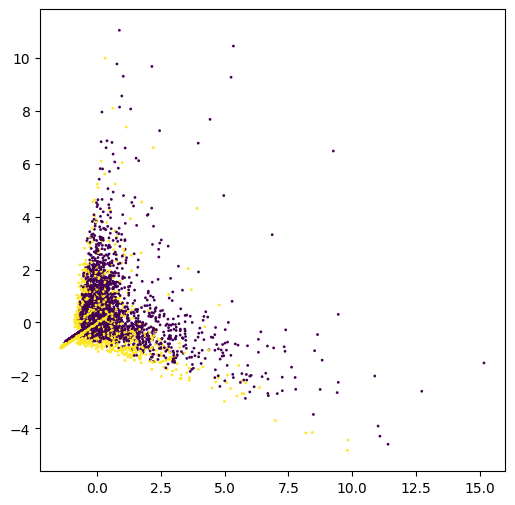

In [166]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_target)
colors = data_target['Transported'].tolist()

plt.figure(figsize=(6, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=1, c=colors)

plt.show()